# I See Dead People: An Analysis

Bryan Bumgardner, Data Scientist  
February - March 2016

### Death is a fact of life.   
That being said, it's worth studying how it fits in our popular culture. During the Metis Data Science bootcamp (shameless plug), while working on another project I discovered bodycounters.com[http://www.bodycounters.com/]. The dedicated volunteers at this site count and categorize the number of deaths in movies, and to date, have counted for over 2,000 movies. Go grab some beers, count the dead people in your favorite movie, and contribute to the site. 

The data are sitting on their site for anyone to see, and it gave me an idea. I reached out to the site and had some correspondence with Dana, who was gracious enough to share a CSV of all the data. I then cross referenced this data with information from another site, thenumbers.com, which shares basic budget and financial information about thousands of movies. I took this data, mashed it together, and asked some questions. 

Thanks again to the volunteers at bodycounters. Y'all are the greatest. Below is a quick data science passion project to analyze and find patterns in this great data you've collected. 

### Major questions:
1. Is the amount of on-screen deaths going up in modern movies?

2. Does a movie's death count have an effect on that movie's domestic gross?
3. How does budget factor into a movie's death count?
4. Is there a relationship between the movie's MPAA rating and body count?
5. What about death count and genre?


### Table of Contents:
1. Reading and combining the data
2. Outputting various data frames
3. Visualizing
4. Conclusions
5. Documentation of the data

In [1]:
import pandas as pd 
import numpy as np
import csv
import os
from datetime import datetime
from future.builtins import next
import re
import logging
import optparse

from difflib import SequenceMatcher

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.linear_model import LinearRegression 
from patsy import dmatrices

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

%matplotlib inline
sns.set(color_codes=True)

### Step 1: read in and clean the data

Deaths data is a csv, provided by the wonderful folks at BodyCounters. 

In [2]:
deaths = pd.read_csv("data/moviesmovies.csv", encoding="latin-1", index_col="movieskey") #might as well make use of their key

deaths["moviename"] = deaths["moviename"].str.rstrip("\t").str.lower() #cleaning some trailing spaces and standardizing for the matching
deaths["deathcomment"] = deaths["deathcomment"].str.rstrip("\t")
deaths["moviename"] = deaths["moviename"].str.replace(".", '')
deaths["moviename"] = deaths["moviename"].str.replace(",", '')
deaths["moviename"] = deaths["moviename"].str.replace("/", '')
deaths["moviename"] = deaths["moviename"].str.replace("'", '')
deaths = deaths.sort(columns="moviename") #it will match faster if we sort these in alphabetical order

deaths.to_csv("deathscleaned.csv", encoding='utf-8') #sending it back out for matching later in OpenRefine

/Users/bryanbumgardner/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


Let's scrape all the movie data - EVER - because we are crazy. And also because I'm not interested in paying for access to their database. 

So what you see below is me scraping all the budgets and domestic box offices for every movie in the alphabetized database. Every letter has a chart with all the movies starting with that letter. I downloaded each webpage from the data source as an HTML webpage then pulled the charts from that, which is less likely to get you banned than hitting up their site with Selenium.

I then mashed the charts together into one GIANT dataframe which will be helpful for record linkage. This needs properly cleaned as well.

In [3]:
path = 'movie_pages/' #where the HTML files are
listing = os.listdir(path) #read the pages from the directory
all_movie_data = pd.DataFrame(columns = ['Release Date', 'Movie', 'Genre', 'ProductionBudget','DomesticBox Officeto Date', 'Trailer'])
# empty dataframe waiting for all the goodies

for i, infile in enumerate(listing): #iterate through the files in the directory 'path'
    temp_list = pd.read_html("movie_pages/"+infile, header=0) #THANK YOU BASED PANDAS. Cleans HTML away and pulls out just the tables.
    temp_frame = pd.DataFrame(temp_list[0]) #temp_list is a list of dataframes. Take the first (and only) one
    all_movie_data = all_movie_data.append(temp_frame) #append this to the master dataframe 
    
del all_movie_data['Trailer'] #not necessary and screwed up the dropna

all_movie_data.rename(columns = {'DomesticBox Officeto Date': 'BoxOffice'}, inplace = True)
all_movie_data = all_movie_data.dropna() #drop unneccessary lines with incomplete data

In [4]:
label_movie_data = all_movie_data #Save this just in case. Might try and do something with the labels, and this has the un-cleaned labels. 

In [5]:
all_movie_data = all_movie_data[all_movie_data.BoxOffice != "$0"]
all_movie_data = all_movie_data[all_movie_data.ProductionBudget != "$0"]
# remove all with $0 (I don't know those values got recorded? Negligence on the site, I think.)

#Formatting all the data so it's actually useful and easier to sum, average, and categorize, along with effective timestamps. 

all_movie_data["Movie"] = all_movie_data["Movie"].str.lower()
all_movie_data["Movie"] = all_movie_data["Movie"].str.replace(".", '')
all_movie_data["Movie"] = all_movie_data["Movie"].str.replace(",", '')
all_movie_data["Movie"] = all_movie_data["Movie"].str.replace(")", '')
all_movie_data["Movie"] = all_movie_data["Movie"].str.replace("'", '') # fuck it we'll do it live. Can you clean this up?
all_movie_data["Movie"] = all_movie_data["Movie"].str.replace("(", '')
all_movie_data["Genre"] = all_movie_data["Genre"].str.lower()
all_movie_data["ProductionBudget"] = all_movie_data["ProductionBudget"].str.strip('$')
all_movie_data["ProductionBudget"] = all_movie_data["ProductionBudget"].str.replace(",", '')
all_movie_data["BoxOffice"] = all_movie_data["BoxOffice"].str.strip('$')
all_movie_data["BoxOffice"] = all_movie_data["BoxOffice"].str.replace(",", '')
all_movie_data = all_movie_data.sort(columns="Movie")


/Users/bryanbumgardner/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:18: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [6]:
all_movie_data["Release Date"] = pd.to_datetime(all_movie_data["Release Date"], format='%b %d, %Y')
# pulled this out to try and identify where my data was getting corrupted
all_movie_data.to_csv("all_movie_data.csv", encoding='utf-8')
# exporting the clean CSV for record linkage

Ok so I'm really lazy and looked into how well these would match with Excel. Turns out the data is filthy and won't match well at all. There are extreme inconsistencies in movie names from both datasets. So I'll have to do fuzzy matching.

### Step 2. Combine the data using record linkage

So the Pandas dataframe-compatible record linkage package, recordlinkage, is turned off right now. I'm still trying to learn how to do this with something called FuzzyWuzzy, which is what you see below.

However, I used OpenRefine to connect the datasets outside of Python, then I'm reading it back into here as a CSV. This was much faster but doesn't scale well, so a true Python script is needed long term.

I did the quick cleaning by using OpenRefine's built-in matching powers mixed with this great fuzzy string reading service that emphasizes reconciliation:
http://okfnlabs.org/reconcile-csv/

In [ ]:
"""#preparing the target dataframe
merged_movie_data = pd.DataFrame(columns = ['Movie', 'ReleaseDate', 'Genre', 'ProductionBudget', 'BoxOffice', 'DeathCount'])
test_dataframe = pd.DataFrame(columns = ['name_ratio', 'name_token_sort_ratio', 'name_partial_ratio', 'match'])
test_death_count = deaths[:100]
test_movie_data = all_movie_data[:100] #gonna see how this works
"""

#This is all under construction!!

In [ ]:
"""for row in test_movie_data.iterrows():
    current_movie_name = test_movie_data["Movie"]
    
    
        for row2 in test_death_count.iterrows():
            second_movie_name = test_death_count["moviename"]
            second_movie_death_count = test_death_count["deathcount"]
            
            
    m = SequenceMatcher(None, current_movie_name, second_movie_name)
    if m.ratio() > 96:
        test_movie_data["DeathCount"] = test_movie_data["DeathCount"].append(second_movie_death_count)
        
        test_death_count.iterrows()
row = next(test_death_count.iterrows())

def send_back_first_title(test_movie_data)
    for row in test_movie_data.iterrows():
        current_movie_name = test_movie_data["Movie"]"""

# Skip past this! 

# XTREME VIOLENCE ALERT

<img src="images/gun.gif">

I discovered the dataset contained LOTS of speculation, guesstimations of body counts on exploded planets, in destroyed spaceships, etc. Many movies had upwards of 1 billion deaths. Knowing this data isn't representative of personal, on-screen images of death, I removed all movies with more than 100,000 recorded deaths. Just in case, I kept the outliers in a second frame, as I noticed many of them were high-budget blockbusters - that could be relevant.

In [7]:
final_data_frame_minus_outliers = pd.read_csv("finalcleaneddata.csv", encoding="latin-1") #no outliers
final_data_frame_complete = pd.read_csv("untouchedfinaldata.csv", encoding="latin-1") #with outliers

In [8]:
final_data_frame_minus_outliers = final_data_frame_minus_outliers.dropna() # In the pairing process, we had some movies with missing values
final_data_frame_complete = final_data_frame_complete.dropna()

final_data_frame_minus_outliers = final_data_frame_minus_outliers.drop("index", 1)
final_data_frame_complete = final_data_frame_complete.drop("index", 1)
#drop some extra stuff that was only useful during linkage. 

final_data_frame_minus_outliers["ReleaseDate"] = pd.to_datetime(final_data_frame_minus_outliers["ReleaseDate"], format="%m/%d/%Y")
final_data_frame_complete["ReleaseDate"] = pd.to_datetime(final_data_frame_complete["ReleaseDate"], format="%m/%d/%Y")
#fitting to my required datetime needs

In [9]:
pd.options.display.max_rows = 1050 #change this if you ever need to explore the data
len(final_data_frame_minus_outliers) #so 1040 movies minus the outliers. 

1040

In [10]:
len(final_data_frame_complete) #count of all movies.

1060

In [11]:
final_data_frame_complete.head(1)

,moviename,BoxOffice,ProductionBudget,Genre,ReleaseDate,deathcount,deathcomment
4,13 going on 30,57139723,30000000,comedy,2004-04-23,0,0


So we have all our stuff and some extra fun comments that will be interesting during visualization. Only twenty movies were removed during the outlier cleaning. 

### Step 3: Statistical Analysis
Now that we have the data, let's revisit the questions we asked and find the best models to answer them.

### Initial Analysis: what factors influence box office revenue?

In [21]:
Y, x = dmatrices('BoxOffice ~ ProductionBudget + Genre + deathcount + ReleaseDate', data=final_data_frame_complete, return_type='dataframe')
# This sets BoxOffice as our dependent variable. Everything after the ~ is combined into intercepts as one massive variable.
model = sm.OLS(Y, x)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              BoxOffice   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.661
Method:                 Least Squares   F-statistic:                     3.419
Date:                Fri, 25 Mar 2016   Prob (F-statistic):           6.11e-23
Time:                        10:30:50   Log-Likelihood:                -19433.
No. Observations:                1060   AIC:                         4.057e+04
Df Residuals:                     206   BIC:                         4.481e+04
Df Model:                         853                                         
Covariance Type:            nonrobust                                         
===================================================================================================================
                                                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------------------------
Intercept                                        1.375e+08   7.21e+07      1.909      0.058     -4.54e+06   2.8e+08
Genre[T.adventure]                               7.866e+07   1.66e+07      4.752      0.000       4.6e+07  1.11e+08
Genre[T.black comedy]                            4.741e+07   2.24e+07      2.113      0.036      3.17e+06  9.17e+07
Genre[T.comedy]                                  3.488e+07    1.3e+07      2.680      0.008      9.22e+06  6.05e+07
Genre[T.drama]                                   4.267e+07   1.19e+07      3.586      0.000      1.92e+07  6.61e+07
Genre[T.horror]                                  4.178e+07    1.3e+07      3.221      0.001      1.62e+07  6.74e+07
Genre[T.musical]                                 -1.07e+08   5.16e+07     -2.073      0.039     -2.09e+08 -5.24e+06
Genre[T.romantic comedy]                         2.258e+07   1.95e+07      1.160      0.247     -1.58e+07  6.09e+07
Genre[T.thriller/suspense]                       5.469e+07   1.33e+07      4.117      0.000      2.85e+07  8.09e+07
Genre[T.western]                                 7.289e+07   4.27e+07      1.709      0.089     -1.12e+07  1.57e+08
ReleaseDate[T.Timestamp('1942-11-16 00:00:00')] -1.764e+08   8.75e+07     -2.015      0.045     -3.49e+08 -3.82e+06
ReleaseDate[T.Timestamp('1951-07-03 00:00:00')] -1.866e+08   8.79e+07     -2.122      0.035      -3.6e+08 -1.32e+07
ReleaseDate[T.Timestamp('1963-05-08 00:00:00')] -1.226e+08   8.79e+07     -1.396      0.164     -2.96e+08  5.06e+07
ReleaseDate[T.Timestamp('1964-04-08 00:00:00')]  -1.15e+08   8.79e+07     -1.309      0.192     -2.88e+08  5.82e+07
ReleaseDate[T.Timestamp('1964-12-22 00:00:00')]  -8.99e+07   8.79e+07     -1.023      0.307     -2.63e+08  8.33e+07
ReleaseDate[T.Timestamp('1965-12-29 00:00:00')] -8.431e+07   8.79e+07     -0.959      0.338     -2.58e+08  8.89e+07
ReleaseDate[T.Timestamp('1967-06-13 00:00:00')] -1.054e+08   8.79e+07     -1.199      0.232     -2.79e+08  6.79e+07
ReleaseDate[T.Timestamp('1968-04-02 00:00:00')] -1.716e+08   8.74e+07     -1.963      0.051     -3.44e+08  7.87e+05
ReleaseDate[T.Timestamp('1968-10-01 00:00:00')] -1.675e+08    8.8e+07     -1.904      0.058     -3.41e+08  5.97e+06
ReleaseDate[T.Timestamp('1969-06-18 00:00:00')] -2.168e+08   9.69e+07     -2.239      0.026     -4.08e+08 -2.59e+07
ReleaseDate[T.Timestamp('1969-10-24 00:00:00')]  -1.15e+08   9.69e+07     -1.188      0.236     -3.06e+08  7.59e+07
ReleaseDate[T.Timestamp('1969-12-18 00:00:00')]  -1.24e+08   8.79e+07     -1.411      0.160     -2.97e+08  4.93e+07
ReleaseDate[T.Timestamp('1971-01-01 00:00:00')] -1.873e+08    8.8e+07     -2.130      0.034     -3.61e+08 -1.39e+07
ReleaseDate[T.Timestamp('1971-10-09 00:00:00')] -1.416e+08   8.75e+

So as you can see, the movie's genre and production budget has more of an effect on the box office than the deathcount, at least in this model.  
Including the release dates (which are all basically unique) greatly improves the P values of the other variables.
### Insight into the genres  
Movies with better chances of guaranteed high profit: adventure, drama, horror, thriller/suspense.
Movies with highly variable chances for high profit: black comedy, comedy
Movies with unclear outcomes: Romantic comedy, westerns
Movies that don't do well: Musicals

In [22]:
# write out in better detail why this is happening. 

### Is the amount of on-screen deaths going up in modern movies?   
Technique to solve this: create an average of deaths per year in movies. 



In [13]:
average_deaths = final_data_frame_minus_outliers[["ReleaseDate", "deathcount", "Genre"]] #taking Genre for visualization. I have a hunch...

In [14]:
average_deaths["Year"] = average_deaths["ReleaseDate"].map(lambda x: x.strftime('%Y'))
# strip just the year from the datetime object and put it into it's own column
# This is a deep copy warning, it's not an error. Ignore this for now, it's not causing a problem. 

/Users/bryanbumgardner/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


A quick statistical test to see if year has a big effect on movie count. Averages aren't great, but this is just a top level view. 

In [15]:
cleaned_average_deaths = average_deaths.groupby(['Year']).mean().reset_index() #group by the year, get the mean of the deathcounts,
# and use reset_index to move the year into it's own column instead of using it as the index. Just personal preference.

x = pd.to_numeric(cleaned_average_deaths["Year"]) #for modeling, these types must be numeric. Originally were floats. 
y = pd.to_numeric(cleaned_average_deaths["deathcount"])

model = sm.OLS(x, y) #Linear Regression with Ordinary Least Squares.
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   Year   R-squared:                       0.294
Model:                            OLS   Adj. R-squared:                  0.280
Method:                 Least Squares   F-statistic:                     22.03
Date:                Fri, 25 Mar 2016   Prob (F-statistic):           1.93e-05
Time:                        10:20:42   Log-Likelihood:                -477.34
No. Observations:                  54   AIC:                             956.7
Df Residuals:                      53   BIC:                             958.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
deathcount     2.9519      0.629      4.694      0.000         1.690     4.213
==============================================================================
Omnibus:                       42.151   Durbin-Watson:                   0.509
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              117.907
Skew:                          -2.334   Prob(JB):                     2.49e-26
Kurtosis:                       8.534   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

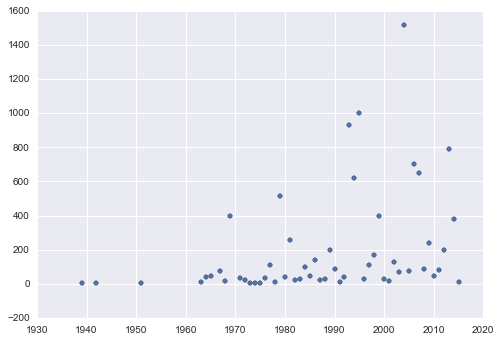

In [16]:
#sns.regplot(x="Year", y="deathcount", data=cleaned_average_deaths)
plt.scatter(x,y)

At first glance, it appears that death counts are going up. This requires a little more analysis - perhaps a histogram or box plot. That can happen later.

### What factors affect a movie's death count, then?

In [28]:
Y, x = dmatrices('deathcount ~ ProductionBudget + Genre + BoxOffice + ReleaseDate', data=final_data_frame_complete, return_type='dataframe')
# left out Box Office because that number is determined chronologically. The amount of deaths won't change post-production of a movie.
model = sm.OLS(Y, x)
results = model.fit()
results.summary()
# Black Comedy and Horror win

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             deathcount   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.537
Method:                 Least Squares   F-statistic:                     2.442
Date:                Fri, 25 Mar 2016   Prob (F-statistic):           8.58e-14
Time:                        10:50:08   Log-Likelihood:                -21302.
No. Observations:                1060   AIC:                         4.431e+04
Df Residuals:                     206   BIC:                         4.855e+04
Df Model:                         853                                         
Covariance Type:            nonrobust                                         
===================================================================================================================
                                                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------------------------
Intercept                                        1.075e+08   4.24e+08      0.253      0.800     -7.28e+08  9.43e+08
Genre[T.adventure]                              -2.366e+08      1e+08     -2.358      0.019     -4.34e+08 -3.88e+07
Genre[T.black comedy]                            4.008e+07   1.32e+08      0.303      0.762     -2.21e+08  3.01e+08
Genre[T.comedy]                                 -3.343e+07   7.72e+07     -0.433      0.665     -1.86e+08  1.19e+08
Genre[T.drama]                                   6.068e+06   7.15e+07      0.085      0.932     -1.35e+08  1.47e+08
Genre[T.horror]                                  3.823e+07   7.75e+07      0.493      0.622     -1.15e+08  1.91e+08
Genre[T.musical]                                -1.207e+08   3.04e+08     -0.397      0.692      -7.2e+08  4.79e+08
Genre[T.romantic comedy]                        -2.133e+07   1.14e+08     -0.187      0.852     -2.46e+08  2.03e+08
Genre[T.thriller/suspense]                      -2.728e+07   8.06e+07     -0.338      0.735     -1.86e+08  1.32e+08
Genre[T.western]                                -3.787e+07   2.51e+08     -0.151      0.880     -5.32e+08  4.56e+08
ReleaseDate[T.Timestamp('1942-11-16 00:00:00')] -1.146e+08   5.15e+08     -0.222      0.824     -1.13e+09  9.02e+08
ReleaseDate[T.Timestamp('1951-07-03 00:00:00')]  -8.45e+07   5.18e+08     -0.163      0.871     -1.11e+09  9.38e+08
ReleaseDate[T.Timestamp('1963-05-08 00:00:00')]  -1.13e+08   5.15e+08     -0.219      0.827     -1.13e+09  9.02e+08
ReleaseDate[T.Timestamp('1964-04-08 00:00:00')] -1.171e+08   5.15e+08     -0.228      0.820     -1.13e+09  8.97e+08
ReleaseDate[T.Timestamp('1964-12-22 00:00:00')] -1.245e+08   5.14e+08     -0.242      0.809     -1.14e+09  8.88e+08
ReleaseDate[T.Timestamp('1965-12-29 00:00:00')] -1.418e+08   5.14e+08     -0.276      0.783     -1.15e+09  8.71e+08
ReleaseDate[T.Timestamp('1967-06-13 00:00:00')] -1.392e+08   5.14e+08     -0.271      0.787     -1.15e+09  8.75e+08
ReleaseDate[T.Timestamp('1968-04-02 00:00:00')]  9.234e+07   5.15e+08      0.179      0.858     -9.22e+08  1.11e+09
ReleaseDate[T.Timestamp('1968-10-01 00:00:00')] -1.482e+08   5.17e+08     -0.286      0.775     -1.17e+09  8.72e+08
ReleaseDate[T.Timestamp('1969-06-18 00:00:00')]  -8.47e+07   5.72e+08     -0.148      0.882     -1.21e+09  1.04e+09
ReleaseDate[T.Timestamp('1969-10-24 00:00:00')] -1.036e+08   5.67e+08     -0.183      0.855     -1.22e+09  1.01e+09
ReleaseDate[T.Timestamp('1969-12-18 00:00:00')] -1.317e+08   5.15e+08     -0.256      0.798     -1.15e+09  8.83e+08
ReleaseDate[T.Timestamp('1971-01-01 00:00:00')] -9.874e+07   5.19e+08     -0.190      0.849     -1.12e+09  9.24e+08
ReleaseDate[T.Timestamp('1971-10-09 00:00:00')] -1.267e+08   5.14e+

### 5. Documentation of the data:

Budget and financial data of movies: http://www.the-numbers.com/movie/budgets/all